# Water Quality <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), 
[ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene),

## Background
The UN SDG 6.3.2 indicator is the "proportion of bodies of water with good ambient water quality". There are many water quality algorithms, so this notebook compares some. They usually estimate the amount of suspended matter in water.

## Description
This notebook shows results for three empirical algorithms and one spectral index addressing total suspended matter (TSM) in water. It should be noted that these algorithms were developed for specific regions of the world and are not valid universally. In addition, the Landsat-8 data is standard surface reflectance and not water leaving radiance, so the accuracy of the results are likely worse since water radiance is very low and small differences in atmospheric corrections can vastly change the results. Finally, the colorbars (legends) for these results have been removed to avoid showing specific quantities for the TSM results. It is best to use these results to assess coarse spatial and temporal differences (e.g. low, medium, high). With improvements in analysis-ready data (e.g. water leaving radiance) and with in-situ sampling of water bodies for empirical modeling, it will be possible to increase the accuracy of these water quality results and even consider the numerical output.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import load_ard
from deafrica_datahandling import wofs_fuser, mostcommon_crs
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import calc_geomedian
from deafrica_plotting import rgb

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:45209 Dashboard: /user/jcrattz/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app = 'SDG_6_3_2_WaterQuality')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat_range`: The latitude range to analyze (e.g. `(-6.26, -5.86)`).
* `lon_range`: The longitude range to analyze (e.g. `(34.98, 35.36)`).
* `time_range`: The time range to analyze (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers water quality in Lake Sulunga.

**To run the notebook for a different area**, make sure Landsat 8 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Landsat 8 (`ls8_usgs_sr_scene`).

### Select location

In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Northern Lake Manyara, Tanzania
lat_range =  (-3.5935, -3.3885) 
lon_range =  (35.7136, 35.9386)

# Weija Reservoir, Ghana
# lat_range =  (5.541, 5.625) 
# lon_range =  (-0.404, -0.328)

# Lake Sulunga, Tanzania
# lat_range = (-6.26, -5.86)
# lon_range = (34.98, 35.36)

# Time Period
time_range = ('2016-02-15', '2016-02-17')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the data

In [6]:
product = "ls8_usgs_sr_scene"
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': (-30, 30),
    'align': (15, 15),
}
output_crs = mostcommon_crs(dc=dc, product=product, query=query)
landsat_dataset = load_ard(dc=dc,
                           products=[product],
                           measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                           group_by='solar_day',
                           dask_chunks={'time':1, 'x': 2000, 'y': 2000},
                           output_crs=output_crs,
                           **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array


In [7]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:      (time: 1, x: 837, y: 759)
Coordinates:
    spatial_ref  int32 32636
  * y            (y) float64 -3.75e+05 -3.75e+05 ... -3.977e+05 -3.977e+05
  * time         (time) datetime64[ns] 2016-02-16T07:49:41.042103
  * x            (x) float64 8.015e+05 8.015e+05 ... 8.265e+05 8.266e+05
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 759, 837), meta=np.ndarray>
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

### Create a geomedian mosaic and show the water extents

In [8]:
# Create a geomedian mosaic.
land_and_water_composite = calc_geomedian(landsat_dataset).persist()

In [9]:
water = dc.load(product="ga_ls8c_wofs_2",
                group_by='solar_day',
                dask_chunks={'time':1, 'x': 2000, 'y': 2000},
                output_crs=output_crs,
                **query).water == 128

In [10]:
water_composite = water.mean('time').persist()

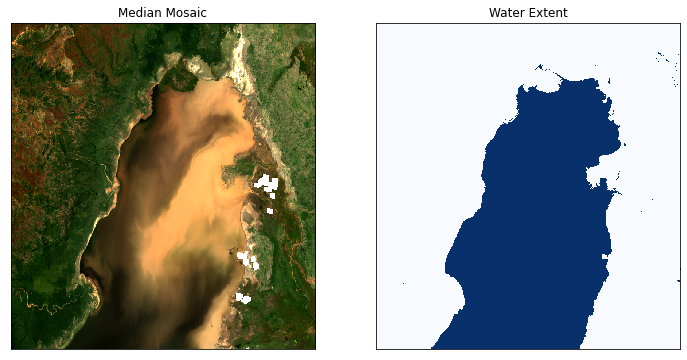

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

rgb(land_and_water_composite, ['red', 'green', 'blue'], ax=ax[0])
water_composite.plot.imshow(ax=ax[1], cmap='Blues', add_colorbar=False)

# Titles
ax[0].set_title('Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Water Extent'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

plt.show()

## Total Suspended Sediment Algorithms

### (1) Lymburner TSM (Total Suspended Matter) Algorithm
Paper: [Lymburner et al. 2016](https://www.sciencedirect.com/science/article/abs/pii/S0034425716301560)

Units of mg/L concentration

TSM for Landsat 7:
$$
LYM7 = 3983 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6246}
$$

TSM for Landsat 8:
$$
LYM8 = 3957 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6436}
$$

Here, we're using Landsat 8, so we'll use the LYM8 function.

In [12]:
def LYM7(dataset):
    return (3983 * ((dataset.green + dataset.red)*0.0001/2)**1.6246)

In [13]:
def LYM8(dataset):
    return (3957 * ((dataset.green + dataset.red)*0.0001/2)**1.6436)

In [14]:
lym8 = LYM8(land_and_water_composite)  # L8 Lymburner TSM

In [15]:
lym8_min = lym8.quantile(0.02).compute().values
lym8_max = lym8.quantile(0.98).compute().values

### (2) Suspended Particulate Model (SPM)
Paper: [Zhongfeng Qiu et.al. 2013](https://www.researchgate.net/publication/260152686_A_simple_optical_model_to_estimate_suspended_particulate_matter_in_Yellow_River_Estuary)

Units of g/m^3 concentration

SPM for Landsat 8:
$$
X = 2.26*(\frac{\text{Red}}{\text{Green}})^3 - 
           5.42*(\frac{\text{Red}}{\text{Green}})^2 +
           5.58*(\frac{\text{Red}}{\text{Green}}) - 0.72
$$

$$
SPM = 10^{X} - 1.43
$$

In [16]:
def SPM_QIU(dataset):
    return (10**(2.26*(dataset.red/dataset.green)**3 - 
                 5.42*(dataset.red/dataset.green)**2 +
                 5.58*(dataset.red/dataset.green) - 0.72) - 1.43)

In [17]:
spm_qiu = SPM_QIU(land_and_water_composite)

In [18]:
spm_qiu_min = spm_qiu.quantile(0.02).compute().values
spm_qiu_max = spm_qiu.quantile(0.98).compute().values

### (3) NDSSI - Normalized Difference Suspended Sediment Index
Paper: [Hossain et al. 2010](https://www.researchgate.net/publication/251236287_Development_of_Remote_Sensing_Based_Index_for_EstimatingMapping_Suspended_Sediment_Concentration_in_River_and_Lake_Environments)

NDSSI for Landsat 7 and 8:
$$
NDSSI = \frac{\text{Blue}-\text{NIR}}{\text{Blue}+\text{NIR}}
$$

The NDSSI value ranges from -1 to +1. Values closer to +1 indicate higher concentration of sediment.

In [19]:
def NDSSI(dataset):
    return ((dataset.blue-dataset.nir)/(dataset.blue+dataset.nir))

In [20]:
ndssi = NDSSI(land_and_water_composite) 

In [21]:
ndssi_min = ndssi.quantile(0.02).compute().values
ndssi_max = ndssi.quantile(0.98).compute().values

### (4) Quang Total Suspended Solids (TSS) Algorithm
Paper: [Quang et al. 2017](https://www.mdpi.com/2073-4441/9/8/570)

Units of mg/L concentration

$$
Quang8 = 380.32 * \text{Red}*0.0001 - 1.7826
$$

In [22]:
def QUANG8(dataset):
    return (380.32 * (dataset.red)*0.0001 - 1.7826)

In [23]:
quang8 = QUANG8(land_and_water_composite) 

In [24]:
quang8_min = quang8.quantile(0.02).compute().values
quang8_max = quang8.quantile(0.98).compute().values

## Compare the algorithms' outputs

Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)


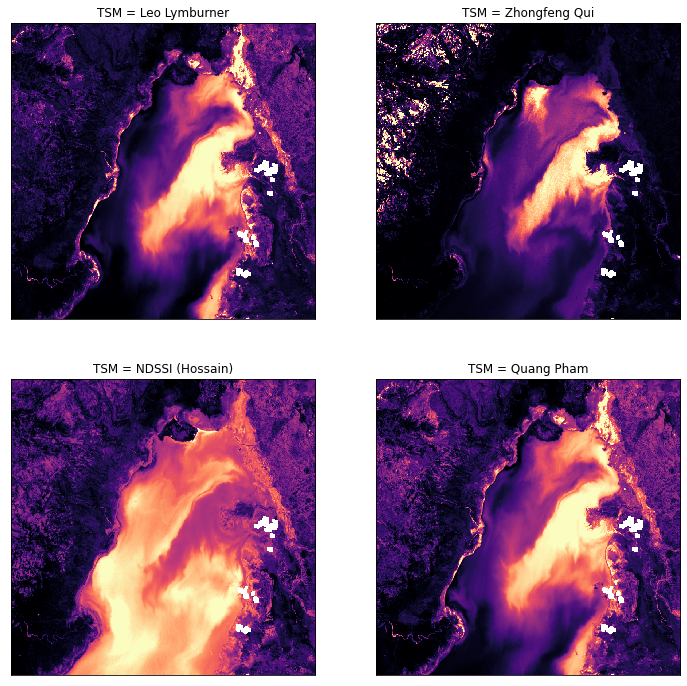

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

(lym8).plot.imshow(ax=ax[0,0], cmap = "magma", add_colorbar=False,
                   vmin=lym8_min, vmax=lym8_max)
(spm_qiu).plot.imshow(ax=ax[0,1], cmap = "magma", add_colorbar=False,
                      vmin=spm_qiu_min, vmax=spm_qiu_max)
(ndssi).plot.imshow(ax=ax[1,0], cmap = "magma", add_colorbar=False,
                    vmin=ndssi_min, vmax=ndssi_max)
(quang8).plot.imshow(ax=ax[1,1], cmap = "magma", add_colorbar=False,
                     vmin=quang8_min, vmax=quang8_max)

print('Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)')

# Titles
ax[0,0].set_title('TSM = Leo Lymburner'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('TSM = Zhongfeng Qui'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('TSM = NDSSI (Hossain)'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('TSM = Quang Pham'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible `datacube` version:** 

In [26]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)